# Results Checker for Predictions

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

directory = 'C:/Users/99451/Desktop/MODEL/2025/dixon_coles_model_predictions/_predictions.xlsx'
predictions = pd.read_excel(directory)
predictions['League'] = predictions['League'].str.capitalize()

predictions.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U
1619,Italy,Genoa,Fiorentina,4.28,14.62,80.76,0-2,18.90,85.04,95.38,89.03,70.01,50.77,69.97,48.67,12.86,42.51,44.51,0-0,55.37,57.37,87.02,64.98,72.28,49.70,94.40,15.20,78.91,96.37,43.57
1620,Italy,AS Roma,Torino,28.82,35.72,35.46,1-1,64.54,64.28,71.18,72.00,41.77,78.87,91.01,51.58,20.19,54.66,25.14,0-0,74.85,45.33,79.80,51.51,84.03,66.98,71.17,30.39,35.32,89.88,86.98
1621,Italy,Como,Lazio,19.65,28.17,52.17,1-1,47.82,71.82,80.34,84.38,59.61,62.75,80.02,61.71,17.94,38.54,43.34,0-0,56.48,61.28,81.88,71.80,64.62,68.67,85.43,32.31,57.38,88.77,69.63
1622,Switzerland,Grasshopper,Lugano,23.91,20.95,55.15,0-1,44.86,79.06,76.10,65.21,41.48,79.09,91.14,41.65,17.36,41.07,41.47,0-0,58.43,58.83,82.54,66.89,72.06,57.08,77.58,20.78,44.06,94.57,81.00
1623,Switzerland,Servette,Luzern,48.57,17.41,33.98,2-1,65.98,82.55,51.39,88.03,74.02,46.13,65.61,70.85,63.51,27.43,8.07,1-0,90.94,71.58,35.50,78.11,56.01,87.92,82.46,62.44,51.97,64.49,74.56


# Finding Game Results

In [2]:
final =  pd.DataFrame()
liqa = ''
unique_leagues = predictions['League'].unique().tolist()

for i in unique_leagues:
    URL = "https://www.soccerstats.com/results.asp?league=" + i + "&pmtype=bydate"
    page = requests.get(URL)
    liqa = i
    soup = BeautifulSoup(page.content, "html.parser")
    results = soup.find(id="btable")
    sth = results.find_all("tr", class_="odd")
    sth


    date, league, home, away, ft, ht = [], [], [], [], [],[]
    for i in sth:
        date.append(i.find_all("td", align = 'right')[0].get_text(strip=True))
        league.append(liqa.capitalize())
        home.append(i.find_all("td", align = 'right')[1].get_text(strip=True))
        away.append(i.find("td", align = "left").get_text(strip = True))
        ft.append(i.find_all("td", align = 'center')[0].get_text(strip = True))
        try:
            ht.append(i.find_all("td", align = 'center')[2].get_text(strip = True))
        except IndexError as e:
            ht.append('NA')#print("Last output before error occurred:", i.find_all("td", align = 'center'))

    data = {'Date': date, 'League': league,'Home': home, 'Away': away, 'FT': ft, 'HT': ht}

# Create a DataFrame from the dictionary
    df = pd.DataFrame(data)

# Replace empty strings with NaN
    #next_df = df[(df['Date'] == formatted_date) & (df['HT'] == '')]
    df.replace('', pd.NA, inplace=True)

# Drop rows with NaN values
    df_cleaned = df.dropna()

#For Half-Time Results
    hthg, htag = [], []
    for i in df_cleaned['HT']:
        if i == 'NA':
            hthg.append('NA')
            htag.append('NA')
        elif i == '+' or i == '-':
            hthg.append('NA')
            htag.append('NA')
        else:
            try:
                hthg.append(int(i[1]))
                htag.append(int(i[3]))
            except IndexError as e:
                print("Last output before error occurred:", i)



#For Full-Time Results
    hg, ag, tg = [], [], []
    for i in df_cleaned['FT']:
        if len(i) < 5 or ':' in i:
            hg.append('NA')
            ag.append('NA')
            tg.append('NA')
        else:
            try:
                hghg = int(i.split(' - ')[0])
                hg.append(hghg)
                agag = int(i.split(' - ')[1])
                ag.append(agag)
                tg.append(hghg + agag)
            except:
                print(hghg + agag)

    
    df_cleaned['FTHG'], df_cleaned['FTAG'], df_cleaned['FTTG'] = hg, ag, tg
    df_cleaned['HTHG'], df_cleaned['HTAG'] = hthg, htag
    df_cleaned['HTTG'] = df_cleaned['HTHG'] + df_cleaned['HTAG']
    
    final = pd.concat([final, df_cleaned], ignore_index=True)
    
final = final[final['HT'] != 'NA']

# Example: Fix the 'date' column by removing the weekday and extra punctuation
final['Date'] = final['Date'].str.extract(r'(\d{1,2} \w{3})')  # Extract day and month part
final['Date'] = final['Date'] + ' 2024'  # Append the year

# Convert to datetime format
final['Date'] = pd.to_datetime(final['Date'], format='%d %b %Y', errors='coerce')

# Filter rows before September 6th, 2024
final_filtered = final[final['Date'] >= pd.Timestamp('2024-09-06')]
combined = pd.concat([final_filtered.head(), final_filtered.tail()])

combined

,Date,League,Home,Away,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
39,2024-09-13,Spain,Real Betis,Leganes,2 - 0,(0-0),2,0,2,0,0,0
40,2024-09-14,Spain,Mallorca,Villarreal,1 - 2,(0-1),1,2,3,0,1,1
41,2024-09-14,Spain,Espanyol,Alaves,3 - 2,(1-1),3,2,5,1,1,2
42,2024-09-14,Spain,Sevilla FC,Getafe,1 - 0,(1-0),1,0,1,1,0,1
43,2024-09-14,Spain,Real Sociedad,Real Madrid,0 - 2,(0-0),0,2,2,0,0,0
5531,2024-10-26,Portugal2,Benfica B,Tondela,1 - 3,(1-0),1,3,4,1,0,1
5532,2024-10-27,Portugal2,Torreense,Alverca,1 - 0,(1-0),1,0,1,1,0,1
5533,2024-10-27,Portugal2,Felgueiras,Maritimo,1 - 3,(1-2),1,3,4,1,2,3
5534,2024-10-27,Portugal2,Leixoes,FC Porto B,3 - 0,(2-0),3,0,3,2,0,2
5535,2024-10-28,Portugal2,Mafra,Uniao de Leiria,2 - 1,(1-0),2,1,3,1,0,1


# Choosing the matches that are on the xlsx and taking their results

In [3]:
# Combine df and final based on 'League', 'Home', and 'Away'
combined_df = pd.merge(predictions, final_filtered, on=['League', 'Home', 'Away'], how='left')
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df = combined_df.dropna(subset=['Date'])
combined_df = combined_df.drop_duplicates(subset=['Home', 'Away'])
combined_df = combined_df.reset_index(drop=True) #Regularize index of combined_df
combined_df.tail()

,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG
1582,Scotland,St. Mirren,St. Johnstone,50.75,18.09,31.11,2-1,68.84,81.86,49.20,88.24,73.59,46.68,66.15,70.50,53.92,23.65,20.16,1-0,77.57,74.08,43.81,89.21,32.72,88.52,81.03,63.72,49.53,63.12,76.63,2024-10-30,3 - 1,(1-1),3.0,1.0,4.0,1.0,1.0,2.0
1583,Scotland,Aberdeen,Rangers,42.39,29.34,28.27,1-0,71.73,70.66,57.61,49.00,24.62,90.49,96.96,30.34,30.00,39.61,30.31,0-0,69.61,60.31,69.92,71.57,66.04,62.60,51.78,25.82,16.61,92.27,96.22,2024-10-30,2 - 1,(1-0),2.0,1.0,3.0,1.0,0.0,1.0
1584,Switzerland,BSC Young Boys,FC Basel,16.01,14.49,69.43,0-1,30.50,85.44,83.92,82.33,64.09,57.92,76.16,54.33,17.50,29.33,52.55,0-1,46.83,70.05,81.88,81.16,53.21,62.18,90.22,25.43,67.57,92.38,58.76,2024-10-30,3 - 2,(0-1),3.0,2.0,5.0,0.0,1.0,1.0
1585,Switzerland,Sion,FC Zurich,37.76,22.66,39.58,0-1,60.42,77.34,62.24,63.88,40.21,80.08,91.71,43.66,23.65,36.20,40.00,0-0,59.85,63.65,76.20,74.45,63.74,67.64,68.80,31.13,32.46,89.47,88.70,2024-10-30,0 - 2,(0-0),0.0,2.0,2.0,0.0,0.0,0.0
1586,Switzerland,St. Gallen,Winterthur,86.11,8.22,5.34,2-0,94.33,91.45,13.56,84.68,66.99,54.36,73.15,38.20,70.26,26.30,2.26,1-0,96.56,72.52,28.56,74.63,59.30,94.33,41.49,78.68,10.17,43.91,97.93,2024-10-30,2 - 2,(1-1),2.0,2.0,4.0,1.0,1.0,2.0


# Checking Predictions To See if Correct or Not

In [4]:
ftrs = []
ftscs = []
dcs = []
overs15 = []
overs25 = []
unders35 = []
unders45 = []
bttss = []
htrs = []
htdcs = []
htscs = []
htovers05 = []
htunders15 = []
homeovers05 = []
awayovers05 = []
homeovers15 = []
awayovers15 = []
homeunders25 = []
awayunders25 = []

for i in range(len(combined_df)):
    full_time_results = [combined_df['FT1'].iloc[i], combined_df['FTX'].iloc[i], combined_df['FT2'].iloc[i]]
    if full_time_results.index(max(full_time_results)) == 0 and combined_df['FTHG'].iloc[i] > combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 1 and combined_df['FTHG'].iloc[i] == combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    elif full_time_results.index(max(full_time_results)) == 2 and combined_df['FTHG'].iloc[i] < combined_df['FTAG'].iloc[i]:
        ftrs.append(1)
    else:
        ftrs.append(0)
    
    if combined_df['FTR'].iloc[i] == combined_df['FT'].iloc[i].replace(' ', ''):
        ftscs.append(1)
    else:
        ftscs.append(0)

    double_chances = [combined_df['DC1X'].iloc[i], combined_df['DC12'].iloc[i], combined_df['DCX2'].iloc[i]]
    if double_chances.index(max(double_chances)) == 0 and combined_df['FTHG'].iloc[i] >= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 2 and combined_df['FTHG'].iloc[i] <= combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    elif double_chances.index(max(double_chances)) == 1 and combined_df['FTHG'].iloc[i] != combined_df['FTAG'].iloc[i]:
        dcs.append(1)
    else:
        dcs.append(0)
    
    if combined_df['1.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 1.5:
        overs15.append(1)
    elif combined_df['1.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 1.5:
        overs15.append(1)
    else:
        overs15.append(0)
    
    if combined_df['2.5O'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] > 2.5:
        overs25.append(1)
    elif combined_df['2.5O'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] < 2.5:
        overs25.append(1)
    else:
        overs25.append(0)
    
    if combined_df['3.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 3.5:
        unders35.append(1)
    elif combined_df['3.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 3.5:
        unders35.append(1)
    else:
        unders35.append(0)
    
    if combined_df['4.5U'].iloc[i] > 50 and combined_df['FTTG'].iloc[i] < 4.5:
        unders45.append(1)
    elif combined_df['4.5U'].iloc[i] < 50 and combined_df['FTTG'].iloc[i] > 4.5:
        unders45.append(1)
    else:
        unders45.append(0)

    if combined_df['BTTS'].iloc[i] > 50 and (combined_df['FTHG'].iloc[i] != 0 and combined_df['FTAG'].iloc[i] != 0):
        bttss.append(1)
    elif combined_df['BTTS'].iloc[i] < 50 and (combined_df['FTHG'].iloc[i] == 0 or combined_df['FTAG'].iloc[i] == 0):
        bttss.append(1)
    else:
        bttss.append(0)
    
    half_time_results = [combined_df['HT1'].iloc[i], combined_df['HTX'].iloc[i], combined_df['HT2'].iloc[i]]
    if half_time_results.index(max(half_time_results)) == 0 and combined_df['HTHG'].iloc[i] > combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 1 and combined_df['HTHG'].iloc[i] == combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    elif half_time_results.index(max(half_time_results)) == 2 and combined_df['HTHG'].iloc[i] < combined_df['HTAG'].iloc[i]:
        htrs.append(1)
    else:
        htrs.append(0)
    
    if combined_df['HTR'].iloc[i] == combined_df['HT'].iloc[i].replace('(', '').replace(')', ''):
        htscs.append(1)
    else:
        htscs.append(0)
    
    ht_double_chances = [combined_df['HTDC1X'].iloc[i], combined_df['HTDC12'].iloc[i], combined_df['HTDCX2'].iloc[i]]
    if ht_double_chances.index(max(ht_double_chances)) == 0 and combined_df['HTHG'].iloc[i] >= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 2 and combined_df['HTHG'].iloc[i] <= combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    elif ht_double_chances.index(max(ht_double_chances)) == 1 and combined_df['HTHG'].iloc[i] != combined_df['HTAG'].iloc[i]:
        htdcs.append(1)
    else:
        htdcs.append(0)
    
    if combined_df['HT0.5O'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] > 0.5:
        htovers05.append(1)
    elif combined_df['HT0.5O'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] < 0.5:
        htovers05.append(1)
    else:
        htovers05.append(0)
    
    if combined_df['HT1.5U'].iloc[i] > 50 and combined_df['HTTG'].iloc[i] < 1.5:
        htunders15.append(1)
    elif combined_df['HT1.5U'].iloc[i] < 50 and combined_df['HTTG'].iloc[i] > 1.5:
        htunders15.append(1)
    else:
        htunders15.append(0)
    
    if combined_df['H0.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 0.5:
        homeovers05.append(1)
    elif combined_df['H0.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 0.5:
        homeovers05.append(1)
    else:
        homeovers05.append(0)

    if combined_df['H1.5O'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] > 1.5:
        homeovers15.append(1)
    elif combined_df['H1.5O'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] < 1.5:
        homeovers15.append(1)
    else:
        homeovers15.append(0)
    
    if combined_df['A0.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 0.5:
        awayovers05.append(1)
    elif combined_df['A0.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 0.5:
        awayovers05.append(1)
    else:
        awayovers05.append(0)

    if combined_df['A1.5O'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] > 1.5:
        awayovers15.append(1)
    elif combined_df['A1.5O'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] < 1.5:
        awayovers15.append(1)
    else:
        awayovers15.append(0)
    
    if combined_df['H2.5U'].iloc[i] > 50 and combined_df['FTHG'].iloc[i] < 2.5:
        homeunders25.append(1)
    elif combined_df['H2.5U'].iloc[i] < 50 and combined_df['FTHG'].iloc[i] > 2.5:
        homeunders25.append(1)
    else:
        homeunders25.append(0)
    
    if combined_df['A2.5U'].iloc[i] > 50 and combined_df['FTAG'].iloc[i] < 2.5:
        awayunders25.append(1)
    elif combined_df['A2.5U'].iloc[i] < 50 and combined_df['FTAG'].iloc[i] > 2.5:
        awayunders25.append(1)
    else:
        awayunders25.append(0)

combined_df['FTRP'] = ftrs
combined_df['FTSP'] = ftscs
combined_df['FTDCP'] = dcs
combined_df['1.5OP'] = overs15
combined_df['2.5OP'] = overs25
combined_df['3.5UP'] = unders35
combined_df['4.5UP'] = unders45
combined_df['BTTSP'] = bttss
combined_df['HTRP'] = htrs
combined_df['HTSP'] = htscs
combined_df['HTDCP'] = htdcs
combined_df['HT0.5OP'] = htovers05
combined_df['HT1.5UP'] = htunders15
combined_df['H0.5OP'] = homeovers05
combined_df['A0.5OP'] = awayovers05
combined_df['H1.5OP'] = homeovers15
combined_df['A1.5OP'] = awayovers15
combined_df['H2.5UP'] = homeunders25
combined_df['A2.5UP'] = awayunders25 

combined_df.tail()


,League,Home,Away,FT1,FTX,FT2,FTR,DC1X,DC12,DCX2,1.5O,2.5O,3.5U,4.5U,BTTS,HT1,HTX,HT2,HTR,HTDC1X,HTDC12,HTDCX2,HT0.5O,HT1.5U,H0.5O,A0.5O,H1.5O,A1.5O,H2.5U,A2.5U,Date,FT,HT,FTHG,FTAG,FTTG,HTHG,HTAG,HTTG,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
1582,Scotland,St. Mirren,St. Johnstone,50.75,18.09,31.11,2-1,68.84,81.86,49.20,88.24,73.59,46.68,66.15,70.50,53.92,23.65,20.16,1-0,77.57,74.08,43.81,89.21,32.72,88.52,81.03,63.72,49.53,63.12,76.63,2024-10-30,3 - 1,(1-1),3.0,1.0,4.0,1.0,1.0,2.0,1,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,0,1
1583,Scotland,Aberdeen,Rangers,42.39,29.34,28.27,1-0,71.73,70.66,57.61,49.00,24.62,90.49,96.96,30.34,30.00,39.61,30.31,0-0,69.61,60.31,69.92,71.57,66.04,62.60,51.78,25.82,16.61,92.27,96.22,2024-10-30,2 - 1,(1-0),2.0,1.0,3.0,1.0,0.0,1.0,1,0,1,0,0,1,1,0,0,0,0,1,1,1,1,0,1,1,1
1584,Switzerland,BSC Young Boys,FC Basel,16.01,14.49,69.43,0-1,30.50,85.44,83.92,82.33,64.09,57.92,76.16,54.33,17.50,29.33,52.55,0-1,46.83,70.05,81.88,81.16,53.21,62.18,90.22,25.43,67.57,92.38,58.76,2024-10-30,3 - 2,(0-1),3.0,2.0,5.0,0.0,1.0,1.0,0,0,1,1,1,0,0,1,1,1,1,1,1,1,1,0,1,0,1
1585,Switzerland,Sion,FC Zurich,37.76,22.66,39.58,0-1,60.42,77.34,62.24,63.88,40.21,80.08,91.71,43.66,23.65,36.20,40.00,0-0,59.85,63.65,76.20,74.45,63.74,67.64,68.80,31.13,32.46,89.47,88.70,2024-10-30,0 - 2,(0-0),0.0,2.0,2.0,0.0,0.0,0.0,1,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1
1586,Switzerland,St. Gallen,Winterthur,86.11,8.22,5.34,2-0,94.33,91.45,13.56,84.68,66.99,54.36,73.15,38.20,70.26,26.30,2.26,1-0,96.56,72.52,28.56,74.63,59.30,94.33,41.49,78.68,10.17,43.91,97.93,2024-10-30,2 - 2,(1-1),2.0,2.0,4.0,1.0,1.0,2.0,0,0,1,1,1,0,1,0,0,0,1,1,0,1,0,1,0,0,1


# Checking Statistics Now

Number of games:  1587


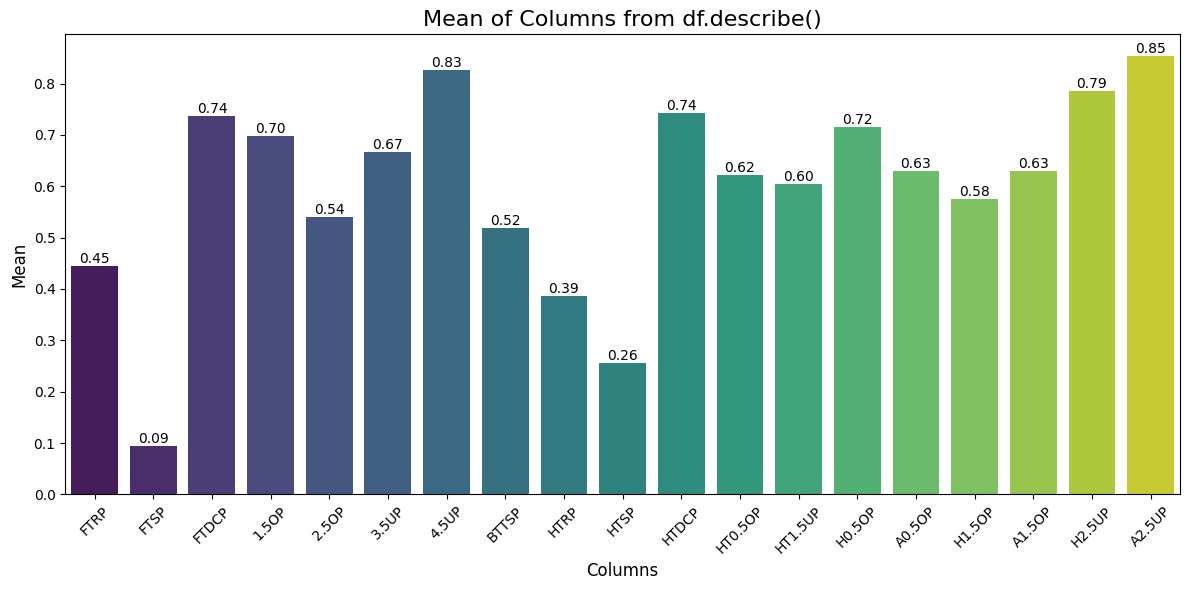

In [5]:
stats_df = combined_df[['League', 'Home', 'Away', 'FTRP', 'FTSP', 'FTDCP', '1.5OP',	'2.5OP', '3.5UP', '4.5UP', 'BTTSP',	
                        'HTRP',	'HTSP',	'HTDCP', 'HT0.5OP',	'HT1.5UP', 'H0.5OP', 'A0.5OP', 'H1.5OP', 'A1.5OP', 'H2.5UP',
                        'A2.5UP']]

import matplotlib.pyplot as plt
import seaborn as sns

print('Number of games: ', len(combined_df))
# Get the summary statistics
desc = stats_df.describe()

# Extract the 'mean' row
means = desc.loc['mean']

# Plotting the means using seaborn or matplotlib
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=means.index, y=means.values, palette="viridis")

# Add titles and labels
plt.title('Mean of Columns from df.describe()', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Mean', fontsize=12)

# Rotate the x labels if necessary for better readability
plt.xticks(rotation=45)

# Add text labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center',
                xytext=(0, 5),  # offset label from bar
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

# Checking Threshold Values

In [6]:
import numpy as np

# Calculate the optimal threshold and best accuracy
def calculate_threshold(percentages, correctness):
    # Normalize the percentages to be between 0 and 1
    percentages = [p / 100 for p in percentages]

    best_threshold = 0
    best_accuracy = 0
    for threshold in np.unique(percentages):
        predicted_correctness = [1 if p >= threshold else 0 for p in percentages]
        accuracy = np.mean(np.array(predicted_correctness) == np.array(correctness))
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    return round(best_threshold * 100, 2), round(best_accuracy * 100, 2)

print('Number of games: ', len(combined_df))
dc1x = combined_df[combined_df['DC1X'] >= combined_df[['DC12', 'DCX2']].max(axis=1)]
dc12 = combined_df[combined_df['DC12'] >= combined_df[['DC1X', 'DCX2']].max(axis=1)]
dcx2 = combined_df[combined_df['DCX2'] >= combined_df[['DC1X', 'DC12']].max(axis=1)]

htdc1x = combined_df[combined_df['HTDC1X'] >= combined_df[['HTDC12', 'HTDCX2']].max(axis=1)]
htdc12 = combined_df[combined_df['HTDC12'] >= combined_df[['HTDC1X', 'HTDCX2']].max(axis=1)]
htdcx2 = combined_df[combined_df['HTDCX2'] >= combined_df[['HTDC1X', 'HTDC12']].max(axis=1)]

dc1x_t, dc1x_a = calculate_threshold(dc1x['DC1X'], dc1x['FTDCP'])
dc12_t, dc12_a = calculate_threshold(dc12['DC12'], dc12['FTDCP'])
dcx2_t, dcx2_a = calculate_threshold(dcx2['DCX2'], dcx2['FTDCP'])

htdc1x_t, htdc1x_a = calculate_threshold(htdc1x['HTDC1X'], htdc1x['HTDCP'])
htdc12_t, htdc12_a = calculate_threshold(htdc12['HTDC12'], htdc12['HTDCP'])
htdcx2_t, htdcx2_a = calculate_threshold(htdcx2['HTDCX2'], htdcx2['HTDCP'])

print(f'DC1X threshold value: {dc1x_t}, accuracy: {dc1x_a}, games {len(dc1x)}      HTDC1X threshold value: {htdc1x_t}, accuracy: {htdc1x_a}, games {len(htdc1x)}')
print(f'DC12 threshold value: {dc12_t}, accuracy: {dc12_a}, games {len(dc12)}      HTDC12 threshold value: {htdc12_t}, accuracy: {htdc12_a}, games {len(htdc12)}')
print(f'DCX2 threshold value: {dcx2_t}, accuracy: {dcx2_a}, games {len(dcx2)}      HTDCX2 threshold value: {htdcx2_t}, accuracy: {htdcx2_a}, games {len(htdcx2)}')
print(" ")

ft1 = combined_df[combined_df['FT1'] >= combined_df[['FTX', 'FT2']].max(axis=1)]
ftx = combined_df[combined_df['FTX'] >= combined_df[['FT1', 'FT2']].max(axis=1)]
ftx = ftx[ftx['FTX'] < 100]
ft2 = combined_df[combined_df['FT2'] >= combined_df[['FT1', 'FTX']].max(axis=1)]

ht1 = combined_df[combined_df['HT1'] >= combined_df[['HTX', 'HT2']].max(axis=1)]
htx = combined_df[combined_df['HTX'] >= combined_df[['HT1', 'HT2']].max(axis=1)]
htx = htx[htx['HTX'] < 100]
ht2 = combined_df[combined_df['HT2'] >= combined_df[['HT1', 'HTX']].max(axis=1)]

ft1_t, ft1_a = calculate_threshold(ft1['FT1'], ft1['FTRP'])
ftx_t, ftx_a = calculate_threshold(ftx['FTX'], ftx['FTRP'])
ft2_t, ft2_a = calculate_threshold(ft2['FT2'], ft2['FTRP'])

ht1_t, ht1_a = calculate_threshold(ht1['HT1'], ht1['HTRP'])
htx_t, htx_a = calculate_threshold(htx['HTX'], htx['HTRP'])
ht2_t, ht2_a = calculate_threshold(ht2['HT2'], ht2['HTRP'])

print(f'FT1 threshold value: {ft1_t}, accuracy: {ft1_a}, games {len(ft1)}       HT1 threshold value: {ht1_t}, accuracy: {ht1_a}, games {len(ht1)}')
print(f'FTX threshold value: {ftx_t}, accuracy: {ftx_a}, games {len(ftx)}       HTX threshold value: {htx_t}, accuracy: {htx_a}, games {len(htx)}')
print(f'FT2 threshold value: {ft2_t}, accuracy: {ft2_a}, games {len(ft2)}       HT2 threshold value: {ht2_t}, accuracy: {ht2_a}, games {len(ht2)}')
print(" ")

over_15 = combined_df[combined_df['1.5O'] > 50]
under_15 = combined_df[combined_df['1.5O'] <= 50]

htover_05 = combined_df[combined_df['HT0.5O'] > 50]
htunder_05 = combined_df[combined_df['HT0.5O'] <= 50]

o15_t, o15_a = calculate_threshold(over_15['1.5O'], over_15['1.5OP'])
u15_t, u15_a = calculate_threshold(under_15['1.5O'], under_15['1.5OP'])
ht05o_t, ht05o_a = calculate_threshold(htover_05['HT0.5O'], htover_05['HT0.5OP'])
ht05u_t, ht05u_a = calculate_threshold(htunder_05['HT0.5O'], htunder_05['HT0.5OP'])

print(f'1.5Over threshold value: {o15_t}, accuracy: {o15_a}, games {len(over_15)}       HTOver0.5 threshold value: {ht05o_t}, accuracy: {ht05o_a}, games {len(htover_05)}')
print(f'1.5Under threshold value: {u15_t}, accuracy: {u15_a}, games {len(under_15)}     HTUnder0.5 threshold value: {ht05u_t}, accuracy: {ht05u_a}, games {len(htunder_05)}')
print(" ")

over_25 = combined_df[combined_df['2.5O'] > 50]
under_25 = combined_df[combined_df['2.5O'] <= 50]

htover_15 = combined_df[combined_df['HT1.5U'] <= 50]
htunder_15 = combined_df[combined_df['HT1.5U'] > 50]

o25_t, o25_a = calculate_threshold(over_25['2.5O'], over_25['2.5OP'])
u25_t, u25_a = calculate_threshold(under_25['2.5O'], under_25['2.5OP'])
ht15o_t, ht15o_a = calculate_threshold(htover_15['HT1.5U'], htover_15['HT1.5UP'])
ht15u_t, ht15u_a = calculate_threshold(htunder_15['HT1.5U'], htunder_15['HT1.5UP'])

print(f'2.5Over threshold value: {o25_t}, accuracy: {o25_a}, games {len(over_25)}       HTOver1.5 threshold value: {ht15o_t}, accuracy: {ht15o_a}, games {len(htover_15)}')
print(f'2.5Under threshold value: {u25_t}, accuracy: {u25_a}, games {len(under_25)}     HTUnder1.5 threshold value: {ht15u_t}, accuracy: {ht15u_a}, games {len(htunder_15)}')
print(" ")

over_35 = combined_df[combined_df['3.5U'] <= 50]
under_35 = combined_df[combined_df['3.5U'] > 50]

home_over_05 = combined_df[combined_df['H0.5O'] > 50]
home_under_05 = combined_df[combined_df['H0.5O'] <= 50]

o35_t, o35_a = calculate_threshold(over_35['3.5U'], over_35['3.5UP'])
u35_t, u35_a = calculate_threshold(under_35['3.5U'], under_35['3.5UP'])

hover_t, hover_a = calculate_threshold(home_over_05['H0.5O'], home_over_05['H0.5OP'])
hunder_t, hunder_a = calculate_threshold(home_under_05['H0.5O'], home_under_05['H0.5OP'])

print(f'3.5Over threshold value: {o35_t}, accuracy: {o35_a} games {len(over_35)}        HomeOver0.5 threshold: {hover_t}, accuracy: {hover_a}, games {len(home_over_05)}')
print(f'3.5Under threshold value: {u35_t}, accuracy: {u35_a} games {len(under_35)}      HomeUnder0.5 threshold: {hunder_t}, accuracy: {hunder_a}, games {len(home_under_05)}')
print(" ")

over_45 = combined_df[combined_df['4.5U'] <= 50]
under_45 = combined_df[combined_df['4.5U'] > 50]

away_over_05 = combined_df[combined_df['A0.5O'] > 50]
away_under_05 = combined_df[combined_df['A0.5O'] <= 50]

o45_t, o45_a = calculate_threshold(over_45['4.5U'], over_45['4.5UP'])
u45_t, u45_a = calculate_threshold(under_45['4.5U'], under_45['4.5UP'])
aover_t, aover_a = calculate_threshold(away_over_05['A0.5O'], away_over_05['A0.5OP'])
aunder_t, aunder_a = calculate_threshold(away_under_05['A0.5O'], away_under_05['A0.5OP'])

print(f'4.5Over threshold value: {o45_t}, accuracy: {o45_a}, games {len(over_45)}       AwayOver0.5 threshold: {aover_t}, accuracy: {aover_a}, games {len(away_over_05)}')
print(f'4.5Under threshold value: {u45_t}, accuracy: {u45_a}, games {len(under_45)}     AwayUnder0.5 threshold: {aunder_t}, accuracy: {aunder_a}, games {len(away_under_05)}')
print(" ")

btts = combined_df[combined_df['BTTS'] > 50]
otts = combined_df[combined_df['BTTS'] <= 50]

home_over_15 = combined_df[combined_df['H1.5O'] > 50]
home_under_15 = combined_df[combined_df['H1.5O'] <= 50]
away_over_15 = combined_df[combined_df['A1.5O'] > 50]
away_under_15 = combined_df[combined_df['A1.5O'] <= 50]

btts_t, btts_a = calculate_threshold(btts['BTTS'], btts['BTTSP'])
otts_t, otts_a = calculate_threshold(otts['BTTS'], otts['BTTSP'])
hover15_t, hover15_a = calculate_threshold(home_over_15['H1.5O'], home_over_15['H1.5OP'])
hunder15_t, hunder15_a = calculate_threshold(home_under_15['H1.5O'], home_under_15['H1.5OP'])
aover15_t, aover15_a = calculate_threshold(away_over_15['A1.5O'], away_over_15['A1.5OP'])
aunder15_t, aunder15_a = calculate_threshold(away_under_15['A1.5O'], away_under_15['A1.5OP'])

print(f'BTTS threshold value: {btts_t}, accuracy: {btts_a}, games: {len(btts)},     HomeOver1.5 T: {hover15_t}, A: {hover15_a}, G: {len(home_over_15)} HomeUnder1.5 T: {hunder15_t}, A: {hunder15_a}, G:{len(home_under_15)}')
print(f'OTTS threshold value: {otts_t}, accuracy: {otts_a}, games: {len(otts)}      AwayOver1.5 T: {aover15_t}, A: {aover15_a}, G: {len(away_over_15)} AwayUnder1.5 T: {aunder15_t}, A: {aunder15_a}, G:{len(away_under_15)}')
print(" ")

Number of games:  1587
DC1X threshold value: 66.7, accuracy: 79.21, games 712      HTDC1X threshold value: 9.04, accuracy: 78.78, games 919
DC12 threshold value: 68.18, accuracy: 73.53, games 476      HTDC12 threshold value: 76.06, accuracy: 60.0, games 90
DCX2 threshold value: 49.08, accuracy: 64.66, games 399      HTDCX2 threshold value: 0.08, accuracy: 70.57, games 581
 
FT1 threshold value: 52.81, accuracy: 57.83, games 875       HT1 threshold value: 80.05, accuracy: 60.25, games 483
FTX threshold value: 88.16, accuracy: 67.93, games 184       HTX threshold value: 80.31, accuracy: 57.73, games 809
FT2 threshold value: 84.34, accuracy: 63.57, games 527       HT2 threshold value: 81.62, accuracy: 74.01, games 277
 
1.5Over threshold value: 50.12, accuracy: 75.36, games 1396       HTOver0.5 threshold value: 50.06, accuracy: 70.58, games 1261
1.5Under threshold value: 49.76, accuracy: 70.68, games 191     HTUnder0.5 threshold value: 50.0, accuracy: 69.63, games 326
 
2.5Over threshold 

# Checking League Stats

In [7]:
df_dropped = stats_df.drop(columns=['Home', 'Away'])

# Ensure 'League' is treated as categorical if needed
df_dropped['League'] = df_dropped['League'].astype('category')

# Group by 'League' and calculate mean for numeric columns
grouped_means = df_dropped.groupby('League').mean()

# Reset index to include 'League' as a column in the result
grouped_means = grouped_means.reset_index()

#Calculate average row-vise
numeric_cols = grouped_means.select_dtypes(include='number')
grouped_means['Average'] = numeric_cols.mean(axis=1)
league_counts = df_dropped.groupby('League').size().reset_index(name='Matches')
grouped_df = grouped_means.merge(league_counts, on='League', how='left')

# Reorder the columns: 'League', then 'count', followed by the mean columns
columns = ['League', 'Average', 'Matches'] + [col for col in grouped_df.columns if col not in ['League', 'Average', 'Matches']]

# Reassign the DataFrame with reordered columns
grouped_df = grouped_df[columns]
grouped_df = grouped_df[grouped_df['Matches'] > 9]
grouped_df.sort_values(by = 'Average', ascending = False)


,League,Average,Matches,FTRP,FTSP,FTDCP,1.5OP,2.5OP,3.5UP,4.5UP,BTTSP,HTRP,HTSP,HTDCP,HT0.5OP,HT1.5UP,H0.5OP,A0.5OP,H1.5OP,A1.5OP,H2.5UP,A2.5UP
4,Brazil,0.644019,55,0.472727,0.200000,0.800000,0.654545,0.509091,0.709091,0.890909,0.563636,0.545455,0.345455,0.854545,0.672727,0.654545,0.781818,0.545455,0.600000,0.745455,0.745455,0.945455
33,Spain,0.636756,61,0.475410,0.114754,0.737705,0.622951,0.622951,0.770492,0.836066,0.491803,0.540984,0.377049,0.737705,0.622951,0.786885,0.639344,0.524590,0.655738,0.770492,0.836066,0.934426
38,Usa,0.635294,85,0.494118,0.082353,0.823529,0.858824,0.623529,0.611765,0.776471,0.647059,0.470588,0.211765,0.788235,0.741176,0.647059,0.835294,0.788235,0.552941,0.552941,0.752941,0.811765
35,Sweden,0.633727,49,0.448980,0.061224,0.775510,0.795918,0.551020,0.836735,0.979592,0.489796,0.326531,0.306122,0.775510,0.530612,0.653061,0.714286,0.632653,0.591837,0.734694,0.918367,0.918367
29,Portugal,0.624060,35,0.542857,0.085714,0.914286,0.571429,0.457143,0.657143,0.828571,0.628571,0.457143,0.257143,0.857143,0.628571,0.657143,0.685714,0.657143,0.685714,0.685714,0.800000,0.800000
0,Argentina,0.622426,69,0.420290,0.115942,0.724638,0.536232,0.579710,0.869565,0.927536,0.463768,0.521739,0.362319,0.797101,0.579710,0.695652,0.652174,0.434783,0.507246,0.855072,0.855072,0.927536
27,Norway,0.615038,35,0.571429,0.085714,0.828571,0.742857,0.714286,0.600000,0.800000,0.600000,0.342857,0.314286,0.742857,0.685714,0.542857,0.685714,0.628571,0.657143,0.657143,0.685714,0.800000
23,Mexico,0.614630,59,0.491525,0.118644,0.677966,0.610169,0.576271,0.728814,0.796610,0.576271,0.389831,0.355932,0.779661,0.677966,0.677966,0.694915,0.542373,0.661017,0.661017,0.796610,0.864407
10,England3,0.607551,92,0.510870,0.097826,0.706522,0.706522,0.586957,0.663043,0.782609,0.565217,0.391304,0.271739,0.760870,0.630435,0.608696,0.706522,0.673913,0.586957,0.608696,0.782609,0.902174
3,Belgium,0.605263,42,0.404762,0.166667,0.690476,0.761905,0.571429,0.714286,0.857143,0.476190,0.476190,0.309524,0.738095,0.642857,0.404762,0.714286,0.619048,0.571429,0.666667,0.809524,0.904762
